Imports


In [1]:
from pathlib import Path
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

PROJECT_ROOT = Path.cwd().parent  # notebooks/ -> project root
DB_PATH = PROJECT_ROOT / "data_processed" / "pap.db"
DB_PATH.exists(), DB_PATH


(True,
 WindowsPath('d:/Preuzimanja/PZAP_PROJEKT/PAP_PROJEKT/data_processed/pap.db'))

Helper za čitanje tablica

In [2]:
def read_table(name: str) -> pd.DataFrame:
    conn = sqlite3.connect(DB_PATH)
    try:
        return pd.read_sql_query(f"SELECT * FROM {name};", conn)
    finally:
        conn.close()

dt_yearly = read_table("dt_yearly")
wb_year = read_table("wb_internet_year")
ind = read_table("integrated_individual")

dt_yearly.head(), wb_year.head(), ind.head()


(   Year  daily_minutes  internet_pct
 0  2012             90     38.020353
 1  2013             95     40.499988
 2  2014            104     43.315020
 3  2015            111     46.123280
 4  2016            128     49.483999,
    Year  internet_pct
 0  1960           NaN
 1  1961           NaN
 2  1962           NaN
 3  1963           NaN
 4  1964           NaN,
    age  gender    job_type  daily_social_media_time  number_of_notifications  \
 0   56    Male  Unemployed                 4.180940                       61   
 1   46    Male      Health                 3.249603                       59   
 2   56  Female  Unemployed                 4.381070                       60   
 3   36  Female   Education                 4.089168                       49   
 4   40  Female   Education                 4.097401                       57   
 
    work_hours_per_day  perceived_productivity_score  \
 0            6.753558                      8.040464   
 1            9.169296          

Brzi pregled podataka

In [3]:
def quick_overview(df: pd.DataFrame, name: str):
    print(f"=== {name} ===")
    print("shape:", df.shape)
    print("missing ratio (top 10):")
    miss = (df.isna().mean().sort_values(ascending=False) * 100).head(10)
    display(miss.to_frame("missing_%"))
    print()

quick_overview(dt_yearly, "dt_yearly")
quick_overview(wb_year, "wb_internet_year")
quick_overview(ind, "integrated_individual")


=== dt_yearly ===
shape: (13, 3)
missing ratio (top 10):


,missing_%
Year,0.0
daily_minutes,0.0
internet_pct,0.0



=== wb_internet_year ===
shape: (65, 2)
missing ratio (top 10):


,missing_%
internet_pct,46.153846
Year,0.000000



=== integrated_individual ===
shape: (23730, 15)
missing ratio (top 10):


,missing_%
stress_level,6.316898
gender,0.000000
age,0.000000
daily_social_media_time,0.000000
number_of_notifications,0.000000
work_hours_per_day,0.000000
job_type,0.000000
perceived_productivity_score,0.000000
actual_productivity_score,0.000000
social_platform_preference,0.000000


Graf 1: DT trend po godinama

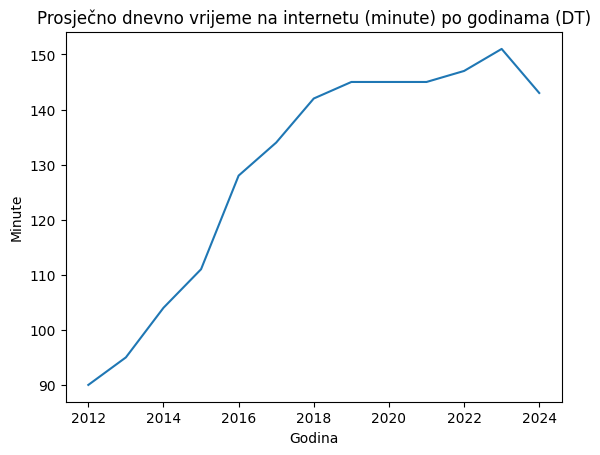

In [4]:
dt_yearly = dt_yearly.sort_values("Year")
plt.figure()
plt.plot(dt_yearly["Year"], dt_yearly["daily_minutes"])
plt.title("Prosječno dnevno vrijeme na internetu (minute) po godinama (DT)")
plt.xlabel("Godina")
plt.ylabel("Minute")
plt.show()


Graf 2: WorldBank trend (internet_pct)

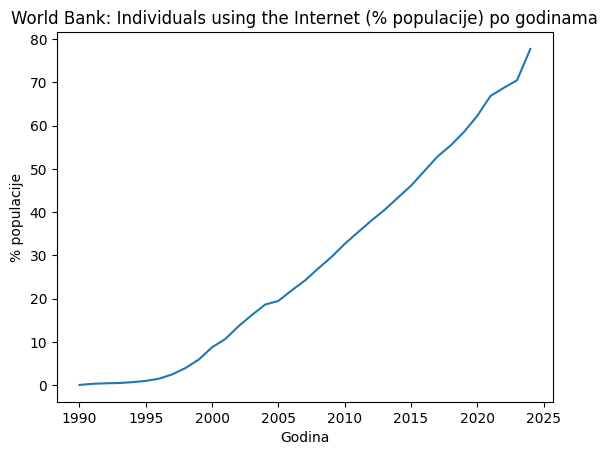

In [5]:
wb_year = wb_year.sort_values("Year")
plt.figure()
plt.plot(wb_year["Year"], wb_year["internet_pct"])
plt.title("World Bank: Individuals using the Internet (% populacije) po godinama")
plt.xlabel("Godina")
plt.ylabel("% populacije")
plt.show()


Join DT + WB po godini + graf + korelacija

Columns: ['Year', 'daily_minutes', 'internet_pct']


,Year,daily_minutes,internet_pct
0,2012,90,38.020353
1,2013,95,40.499988
2,2014,104,43.315020
3,2015,111,46.123280
4,2016,128,49.483999
5,2017,134,52.872149
6,2018,142,55.449201
7,2019,145,58.575574
8,2020,145,62.294095
9,2021,145,66.899287


Missing internet_pct: 0.0
Korelacija daily_minutes vs internet_pct: 0.8855538469368354


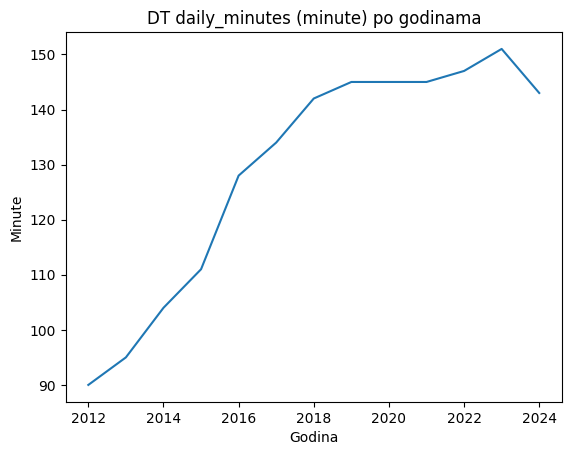

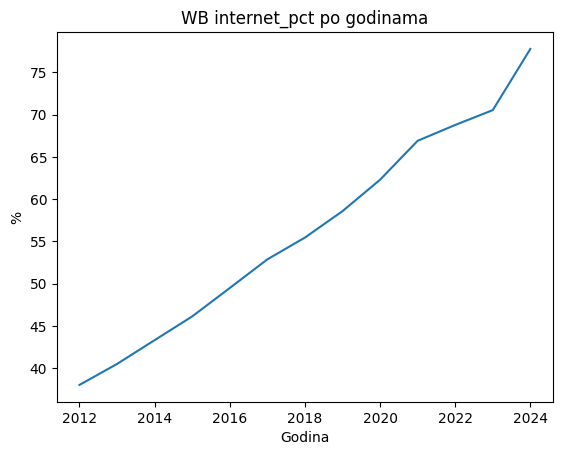

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


dt_tmp = dt_yearly.copy()
wb_tmp = wb_year.copy()


if "internet_pct" not in wb_tmp.columns:
    if "value" in wb_tmp.columns:
        wb_tmp = wb_tmp.rename(columns={"value": "internet_pct"})
    else:
        raise KeyError(
            "Ne mogu naći stupac za postotak interneta. "
            f"wb_year columns={wb_tmp.columns.tolist()}"
        )

# 2) UZMI
#    - iz DT uzmi samo Year i daily_minutes
#    - iz WB uzmi Year i internet_pct
dt_tmp = dt_tmp[["Year", "daily_minutes"]].copy()
wb_tmp = wb_tmp[["Year", "internet_pct"]].copy()

# 3)Normalizacija Year na Int64 
dt_tmp["Year"] = pd.to_numeric(dt_tmp["Year"], errors="coerce").astype("Int64")
wb_tmp["Year"] = pd.to_numeric(wb_tmp["Year"], errors="coerce").astype("Int64")


dt_tmp = dt_tmp.dropna(subset=["Year"])
wb_tmp = wb_tmp.dropna(subset=["Year"])

# 4) Merge
merged = (
    dt_tmp.merge(wb_tmp, on="Year", how="left")
          .sort_values("Year")
          .reset_index(drop=True)
)

print("Columns:", merged.columns.tolist())
display(merged.head(10))

# 5) korelacija 
missing_rate = merged["internet_pct"].isna().mean()
print("Missing internet_pct:", missing_rate)

corr_df = merged[["daily_minutes", "internet_pct"]].dropna()
corr = corr_df.corr(numeric_only=True).iloc[0, 1] if len(corr_df) > 1 else None
print("Korelacija daily_minutes vs internet_pct:", corr)

# 6) Grafovi

plt.figure()
plt.plot(merged["Year"], merged["daily_minutes"])
plt.title("DT daily_minutes (minute) po godinama")
plt.xlabel("Godina")
plt.ylabel("Minute")
plt.show()

plt.figure()
plt.plot(merged["Year"], merged["internet_pct"])
plt.title("WB internet_pct po godinama")
plt.xlabel("Godina")
plt.ylabel("%")
plt.show()


Graf 3: Social media vs productivity (scatter)

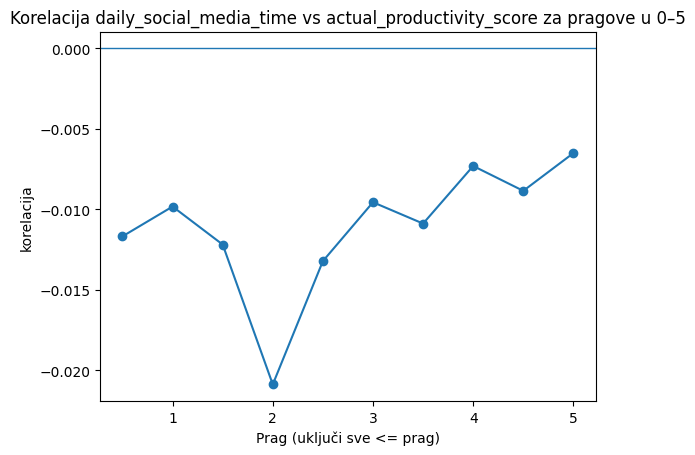

Korelacija za cijeli raspon 0–5: -0.006504157410435344


,threshold,n,corr
0,0.5,2577,-0.011677
1,1.0,3848,-0.009825
2,1.5,5436,-0.012187
3,2.0,7368,-0.020877
4,2.5,9500,-0.013215
5,3.0,11710,-0.009558
6,3.5,14063,-0.010883
7,4.0,16258,-0.007305
8,4.5,18288,-0.008849
9,5.0,19899,-0.006504


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

xcol = "daily_social_media_time"
ycol = "actual_productivity_score"

df = ind[[xcol, ycol]].dropna().copy()
df = df[df[xcol].between(0, 5)].copy()

thresholds = np.arange(0.5, 5.0 + 0.5, 0.5)
rows = []

for t in thresholds:
    sub = df[df[xcol] <= t]
    corr = sub[[xcol, ycol]].corr(numeric_only=True).iloc[0, 1] if len(sub) > 5 else np.nan
    rows.append({"threshold": t, "n": len(sub), "corr": corr})

corr_df = pd.DataFrame(rows)

plt.figure()
plt.plot(corr_df["threshold"], corr_df["corr"], marker="o")
plt.axhline(0, linewidth=1)
plt.xlabel("Prag (uključi sve <= prag)")
plt.ylabel("korelacija")
plt.title(f"Korelacija {xcol} vs {ycol} za pragove u 0–5")
plt.show()
correlation = corr_df.iloc[-1]["corr"] if len(corr_df) > 0 else None
print(f"Korelacija za cijeli raspon 0–5: {correlation}")
display(corr_df)


Graf 4: Time-Wasters on Social Media

Stupci u tablici:


0                              age
1                           gender
2                         job_type
3          daily_social_media_time
4          number_of_notifications
5               work_hours_per_day
6     perceived_productivity_score
7        actual_productivity_score
8                     stress_level
9       social_platform_preference
10            dt_daily_minutes_avg
11       internet_pct_avg_dt_years
12        tw_total_time_spent_mean
13                tw_sessions_mean
14              tw_engagement_mean
dtype: object

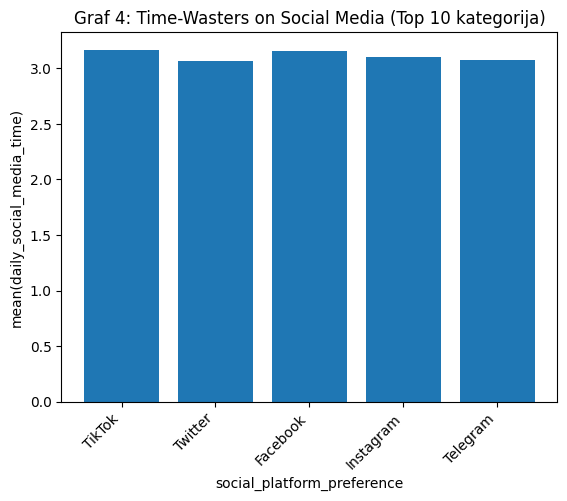

,social_platform_preference,mean,count
0,TikTok,3.167217,4840
1,Twitter,3.067256,4758
2,Facebook,3.159321,4730
3,Instagram,3.102429,4724
4,Telegram,3.076614,4678


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tw = read_table("integrated_individual")  

print("Stupci u tablici:")
display(pd.Series(tw.columns))

def pick_col(cols, keywords):
    cols_low = [c.lower() for c in cols]
    for kw in keywords:
        for c, cl in zip(cols, cols_low):
            if kw in cl:
                return c
    return None


cat_col = pick_col(tw.columns, ["waster", "waste", "activity", "purpose", "reason", "platform", "app", "category"])
num_col = pick_col(tw.columns, ["time", "minutes", "hours", "spent", "daily", "duration"])

if cat_col is None:
    
    obj_cols = tw.select_dtypes(include=["object"]).columns.tolist()
    cat_col = obj_cols[0] if obj_cols else None

if num_col is None:
    
    num_cols = tw.select_dtypes(include=[np.number]).columns.tolist()
    num_col = num_cols[0] if num_cols else None

if cat_col is None or num_col is None:
    raise ValueError(f"Ne mogu naći prikladne stupce. cat_col={cat_col}, num_col={num_col}")

df4 = tw[[cat_col, num_col]].dropna().copy()

g4 = (df4.groupby(cat_col)[num_col]
      .agg(mean="mean", count="count")
      .sort_values(["count", "mean"], ascending=[False, False])
      .head(10)
      .reset_index())

plt.figure()
plt.bar(g4[cat_col].astype(str), g4["mean"])
plt.xticks(rotation=45, ha="right")
plt.xlabel(cat_col)
plt.ylabel(f"mean({num_col})")
plt.title("Graf 4: Time-Wasters on Social Media (Top 10 kategorija)")
plt.show()

display(g4)
